In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime


%matplotlib inline
from RL_env.config import config
from RL_env.marketdata.yahoodownloader import YahooDownloader
from RL_env.preprocessing.preprocessors import FeatureEngineer
from RL_env.preprocessing.data import data_split
from RL_env.env.env_stocktrading import StockTradingEnv
from RL_env.model.models import DRLAgent,DRLEnsembleAgent
from RL_env.trade.backtest import backtest_stats, get_baseline, backtest_plot
from RL_env.trade.backtest import convert_daily_return_to_pyfolio_ts,get_daily_return


from pprint import pprint
from pyfolio import timeseries

import sys
sys.path.append("../FinRL-Library")

import itertools

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
start_date=config.START_DATE
end_date=config.END_DATE

In [4]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = config.PRO1_5_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (26420, 8)


In [5]:
# df.to_csv('susa.csv')

In [6]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,14.968750,15.593750,14.687500,15.500000,7843200,AMD,0
1,2000-01-03,32.791668,32.833332,28.645832,31.083332,2792700,BIIB,0
2,2000-01-03,20.500000,20.687500,20.312500,10.456738,276400,ES,0
3,2000-01-03,47.625000,47.687500,45.187500,31.423141,334100,GWW,0
4,2000-01-03,15.125000,15.750000,15.125000,3.880371,112600,WELL,0


In [7]:
df.tail(10)

,date,open,high,low,close,volume,tic,day
26410,2020-12-30,90.779999,92.849998,90.190002,92.290001,25845000,AMD,2
26411,2020-12-30,244.500000,245.059998,242.360001,243.580002,750000,BIIB,2
26412,2020-12-30,84.800003,85.830002,84.800003,84.086540,838700,ES,2
26413,2020-12-30,407.149994,409.769989,402.959991,403.726776,179900,GWW,2
26414,2020-12-30,63.230000,64.580002,63.139999,62.712772,1195200,WELL,2
26415,2020-12-31,92.099998,92.300003,90.870003,91.709999,24930700,AMD,3
26416,2020-12-31,243.470001,245.190002,241.100006,244.860001,978100,BIIB,3
26417,2020-12-31,85.480003,86.610001,84.989998,85.249344,1117000,ES,3
26418,2020-12-31,405.720001,408.850006,402.309998,405.225250,223500,GWW,3
26419,2020-12-31,63.549999,64.739998,62.709999,63.518803,1424900,WELL,3


In [8]:
df.shape

(26420, 8)

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = True)

df = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added user defined features


In [10]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4
0,2000-01-03,14.968750,15.593750,14.687500,15.500000,7843200,AMD,0,0.0,16.299937,13.825063,0.0,-66.666667,100.0,15.500000,15.500000,1.005376,0.695832,-0.056452
5284,2000-01-03,32.791668,32.833332,28.645832,31.083332,2792700,BIIB,0,0.0,16.299937,13.825063,0.0,-66.666667,100.0,31.083332,31.083332,1.005376,0.695832,-0.056452
10568,2000-01-03,20.500000,20.687500,20.312500,10.456738,276400,ES,0,0.0,16.299937,13.825063,0.0,-66.666667,100.0,10.456738,10.456738,-0.663590,-1.089425,-0.056452
15852,2000-01-03,47.625000,47.687500,45.187500,31.423141,334100,GWW,0,0.0,16.299937,13.825063,0.0,-66.666667,100.0,31.423141,31.423141,2.005061,1.100298,-0.056452
21136,2000-01-03,15.125000,15.750000,15.125000,3.880371,112600,WELL,0,0.0,16.299937,13.825063,0.0,-66.666667,100.0,3.880371,3.880371,-0.876512,-2.091614,-0.056452


In [11]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i,:]
    price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values 
    cov_list.append(covs)

df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [12]:
df.shape

(25160, 20)

In [13]:
df.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,14.125000,14.750000,14.125000,14.375000,4863600,AMD,1,-1.266954,17.488072,12.968178,39.175257,-76.161462,26.549249,16.345833,18.960417,2.056291,1.117202,0.040724,"[[0.002947112141313781, 0.00040994880412310457..."
1,2001-01-02,63.083332,63.666668,58.020832,59.250000,5691300,BIIB,1,0.095880,75.095405,57.665012,48.264690,-50.384603,18.702324,63.631944,63.052951,3.121739,1.416275,-0.062315,"[[0.002947112141313781, 0.00040994880412310457..."
2,2001-01-02,24.000000,24.000000,23.312500,12.137883,494500,ES,1,0.380276,12.476217,11.036508,59.435778,100.825680,29.481988,11.366500,10.778033,-0.795141,-1.585434,-0.028351,"[[0.002947112141313781, 0.00040994880412310457..."
3,2001-01-02,35.750000,36.812500,35.437500,25.105249,614000,GWW,1,0.117821,27.725351,21.941272,55.088501,15.587434,30.646330,24.934109,22.765905,1.068338,0.726746,-0.011987,"[[0.002947112141313781, 0.00040994880412310457..."
4,2001-01-02,16.250000,16.375000,16.062500,4.649143,124000,WELL,1,-0.058460,5.021913,4.652647,42.250178,-203.132996,20.336797,4.871048,4.908655,-0.814814,-1.686394,-0.011538,"[[0.002947112141313781, 0.00040994880412310457..."
5,2001-01-03,14.500000,16.375000,14.437500,16.250000,8808100,AMD,2,-1.054734,17.577216,12.966534,43.895707,-25.847469,4.905655,16.202083,18.864583,2.495268,1.251410,0.130435,"[[0.0029999357084603403, 0.0004154477861490622..."
6,2001-01-03,58.854168,63.000000,52.500000,62.104168,12440700,BIIB,2,-0.124183,74.600782,58.590885,50.147213,-68.840639,29.722744,63.807639,63.192882,2.821795,1.340720,0.048172,"[[0.0029999357084603403, 0.0004154477861490622..."
7,2001-01-03,23.687500,24.187500,23.000000,11.848123,388500,ES,2,0.343470,12.445757,11.141018,56.145336,86.715349,21.047254,11.416445,10.804608,-0.809222,-1.656644,-0.023872,"[[0.0029999357084603403, 0.0004154477861490622..."
8,2001-01-03,36.062500,37.562500,35.562500,26.149496,374700,GWW,2,0.241465,27.654254,21.968860,57.833879,47.253051,34.755405,24.957315,22.894419,1.207058,0.791660,0.041595,"[[0.0029999357084603403, 0.0004154477861490622..."
9,2001-01-03,16.125000,16.687500,16.125000,4.830044,127700,WELL,2,-0.049790,5.020961,4.651789,48.360961,-113.747604,3.907056,4.869842,4.906954,-0.815291,-1.688974,0.038911,"[[0.0029999357084603403, 0.0004154477861490622..."


In [14]:
train = data_split(df, config.START_DATE,'2019-01-01')
trade = data_split(df, '2019-01-02', config.END_DATE)

In [15]:
train.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,14.125000,14.750000,14.125000,14.375000,4863600,AMD,1,-1.266954,17.488072,12.968178,39.175257,-76.161462,26.549249,16.345833,18.960417,2.056291,1.117202,0.040724,"[[0.002947112141313781, 0.00040994880412310457..."
0,2001-01-02,63.083332,63.666668,58.020832,59.250000,5691300,BIIB,1,0.095880,75.095405,57.665012,48.264690,-50.384603,18.702324,63.631944,63.052951,3.121739,1.416275,-0.062315,"[[0.002947112141313781, 0.00040994880412310457..."
0,2001-01-02,24.000000,24.000000,23.312500,12.137883,494500,ES,1,0.380276,12.476217,11.036508,59.435778,100.825680,29.481988,11.366500,10.778033,-0.795141,-1.585434,-0.028351,"[[0.002947112141313781, 0.00040994880412310457..."
0,2001-01-02,35.750000,36.812500,35.437500,25.105249,614000,GWW,1,0.117821,27.725351,21.941272,55.088501,15.587434,30.646330,24.934109,22.765905,1.068338,0.726746,-0.011987,"[[0.002947112141313781, 0.00040994880412310457..."
0,2001-01-02,16.250000,16.375000,16.062500,4.649143,124000,WELL,1,-0.058460,5.021913,4.652647,42.250178,-203.132996,20.336797,4.871048,4.908655,-0.814814,-1.686394,-0.011538,"[[0.002947112141313781, 0.00040994880412310457..."
1,2001-01-03,14.500000,16.375000,14.437500,16.250000,8808100,AMD,2,-1.054734,17.577216,12.966534,43.895707,-25.847469,4.905655,16.202083,18.864583,2.495268,1.251410,0.130435,"[[0.0029999357084603403, 0.0004154477861490622..."
1,2001-01-03,58.854168,63.000000,52.500000,62.104168,12440700,BIIB,2,-0.124183,74.600782,58.590885,50.147213,-68.840639,29.722744,63.807639,63.192882,2.821795,1.340720,0.048172,"[[0.0029999357084603403, 0.0004154477861490622..."
1,2001-01-03,23.687500,24.187500,23.000000,11.848123,388500,ES,2,0.343470,12.445757,11.141018,56.145336,86.715349,21.047254,11.416445,10.804608,-0.809222,-1.656644,-0.023872,"[[0.0029999357084603403, 0.0004154477861490622..."
1,2001-01-03,36.062500,37.562500,35.562500,26.149496,374700,GWW,2,0.241465,27.654254,21.968860,57.833879,47.253051,34.755405,24.957315,22.894419,1.207058,0.791660,0.041595,"[[0.0029999357084603403, 0.0004154477861490622..."
1,2001-01-03,16.125000,16.687500,16.125000,4.830044,127700,WELL,2,-0.049790,5.020961,4.651789,48.360961,-113.747604,3.907056,4.869842,4.906954,-0.815291,-1.688974,0.038911,"[[0.0029999357084603403, 0.0004154477861490622..."


In [16]:
train.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
4525,2018-12-28,17.530001,18.309999,17.139999,17.820000,109214400,AMD,4,-0.989704,23.074035,15.900965,43.740490,-108.877037,14.783165,19.720333,21.389000,-0.713575,-1.250278,0.018868,"[[0.0015718591128133681, 0.0001796583356901567..."
4525,2018-12-28,294.500000,298.250000,292.500000,293.519989,1053300,BIIB,4,-8.817648,344.231344,274.796659,41.920108,-104.489074,17.491378,313.315999,318.443999,15.471380,2.801624,-0.003023,"[[0.0015718591128133681, 0.0001796583356901567..."
4525,2018-12-28,64.830002,65.480003,64.470001,60.342251,1095900,ES,4,-0.295668,66.397456,59.359469,48.522223,-123.444426,22.793145,62.564000,60.529195,-0.794419,-1.581913,-0.001698,"[[0.0015718591128133681, 0.0001796583356901567..."
4525,2018-12-28,283.019989,285.859985,280.410004,268.974762,337200,GWW,4,-5.823976,301.567708,249.197401,43.226504,-65.386358,4.821332,280.541396,282.061300,3.457486,1.494585,-0.001631,"[[0.0015718591128133681, 0.0001796583356901567..."
4525,2018-12-28,69.800003,70.330002,68.480003,62.305027,1757200,WELL,4,-0.119826,67.509387,60.780405,51.516586,-82.756931,14.853497,63.775005,60.914720,-0.768361,-1.462575,0.001444,"[[0.0015718591128133681, 0.0001796583356901567..."
4526,2018-12-31,18.150000,18.510000,17.850000,18.459999,84732200,AMD,0,-0.905774,22.831602,15.846398,45.219719,-74.278774,12.242897,19.642000,21.222833,-0.703716,-1.216436,0.035915,"[[0.0015761865192430785, 0.0001829805797452693..."
4526,2018-12-31,294.559998,302.480011,294.200012,300.920013,1064300,BIIB,0,-7.952601,342.175996,274.283009,44.815817,-72.974108,10.113885,312.895000,317.580166,15.301193,2.791238,0.025211,"[[0.0015761865192430785, 0.0001829805797452693..."
4526,2018-12-31,64.650002,65.050003,63.990002,60.687496,1492100,ES,0,-0.349099,66.446966,59.165841,49.590160,-131.029495,26.365842,62.566600,60.597499,-0.798327,-1.601107,0.005721,"[[0.0015761865192430785, 0.0001829805797452693..."
4526,2018-12-31,281.700012,284.850006,279.339996,269.825195,460400,GWW,0,-5.310091,298.136886,249.873200,43.640605,-63.371723,6.560356,279.967395,280.883427,3.446141,1.492037,0.003162,"[[0.0015761865192430785, 0.0001829805797452693..."
4526,2018-12-31,69.599998,69.599998,68.089996,62.340950,1421800,WELL,0,-0.162645,67.513984,60.594380,51.596076,-97.563394,17.867962,63.754347,61.038805,-0.768958,-1.465156,0.000577,"[[0.0015761865192430785, 0.0001829805797452693..."


In [17]:
trade.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2019-01-02,18.010000,19.000000,17.980000,18.830000,87148700,AMD,2,-0.800179,22.588778,15.842221,46.067794,-52.118450,6.093693,19.553333,21.073667,-0.697951,-1.197167,0.020043,"[[0.0015740507037994974, 0.0001831922132499150..."
0,2019-01-02,296.839996,307.130005,296.540009,304.690002,1336500,BIIB,2,-6.883490,338.548087,275.007919,46.228711,-50.056617,2.547273,312.327334,316.939999,15.181094,2.783844,0.012528,"[[0.0015740507037994974, 0.0001831922132499150..."
0,2019-01-02,64.930000,64.949997,63.139999,59.241226,1493400,ES,2,-0.502354,66.565959,58.640460,45.499640,-163.078514,32.296393,62.497215,60.634751,-0.805569,-1.637677,-0.023831,"[[0.0015740507037994974, 0.0001831922132499150..."
0,2019-01-02,278.890015,279.910004,274.589996,264.301788,789200,GWW,2,-5.287574,293.318135,251.112245,41.601859,-86.574782,14.015511,279.026760,279.705923,3.461450,1.495474,-0.020470,"[[0.0015740507037994974, 0.0001831922132499150..."
0,2019-01-02,68.790001,68.919998,66.820000,60.436863,2328100,WELL,2,-0.346233,67.614030,60.041665,47.340240,-153.649286,26.879083,63.688483,61.126574,-0.771334,-1.475492,-0.030543,"[[0.0015740507037994974, 0.0001831922132499150..."
1,2019-01-03,18.420000,18.680000,16.940001,17.049999,117277600,AMD,3,-0.850323,21.647749,16.117250,42.772351,-101.675168,16.475536,19.433000,20.902000,-0.717887,-1.265449,-0.094530,"[[0.001594894022986722, 0.00016751657295380036..."
1,2019-01-03,306.760010,316.690002,305.920013,307.000000,2148600,BIIB,3,-5.783150,334.958573,276.078432,47.087425,-11.554102,10.907318,311.759001,316.355333,17.005866,2.890698,0.007581,"[[0.001594894022986722, 0.00016751657295380036..."
1,2019-01-03,63.549999,64.199997,63.200001,59.203896,1272100,ES,3,-0.619679,66.584795,58.174451,45.399646,-157.469231,32.296393,62.400649,60.658104,-0.807153,-1.645860,-0.000630,"[[0.001594894022986722, 0.00016751657295380036..."
1,2019-01-03,275.410004,276.899994,266.329987,256.140900,891300,GWW,3,-5.860687,286.467294,253.266273,38.829272,-116.073519,25.120966,277.672344,278.409844,3.326420,1.464740,-0.030877,"[[0.001594894022986722, 0.00016751657295380036..."
1,2019-01-03,67.459999,69.160004,67.309998,61.550564,2369600,WELL,3,-0.397281,67.497234,59.788420,49.843470,-115.974896,24.127910,63.634593,61.232461,-0.759700,-1.425869,0.018428,"[[0.001594894022986722, 0.00016751657295380036..."


In [18]:
trade.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
503,2020-12-30,90.779999,92.849998,90.190002,92.290001,25845000,AMD,2,1.298260,97.532017,89.066984,55.686086,17.193127,2.010703,91.054667,86.306000,0.486071,0.396136,0.018429,"[[0.0014872867653209579, 0.000585837045473105,..."
503,2020-12-30,244.500000,245.059998,242.360001,243.580002,750000,BIIB,2,-1.763395,251.787441,240.777555,45.755249,-60.428132,6.008377,245.278332,258.148999,1.639289,0.970510,0.000493,"[[0.0014872867653209579, 0.000585837045473105,..."
503,2020-12-30,84.800003,85.830002,84.800003,84.086540,838700,ES,2,-0.913572,85.909313,81.766698,47.135097,-48.736359,11.346631,84.789057,87.351898,-0.654789,-1.063599,0.001643,"[[0.0014872867653209579, 0.000585837045473105,..."
503,2020-12-30,407.149994,409.769989,402.959991,403.726776,179900,GWW,2,2.857024,412.585351,396.515543,55.449857,-60.434045,6.141235,407.098526,390.754288,3.801325,1.568892,-0.001105,"[[0.0014872867653209579, 0.000585837045473105,..."
503,2020-12-30,63.230000,64.580002,63.139999,62.712772,1195200,WELL,2,0.205616,65.420232,60.453546,53.545648,-30.759951,6.227994,63.088592,59.525777,-0.844665,-1.862173,0.009813,"[[0.0014872867653209579, 0.000585837045473105,..."
504,2020-12-31,92.099998,92.300003,90.870003,91.709999,24930700,AMD,3,1.137948,97.483075,88.912926,54.961757,9.403779,2.010703,91.333000,86.426500,0.462382,0.380066,-0.006285,"[[0.0014696193133957023, 0.0005879266594444048..."
504,2020-12-31,243.470001,245.190002,241.100006,244.860001,978100,BIIB,3,-1.749108,251.711240,240.647756,46.248308,-55.001066,8.535083,245.146665,257.544166,1.669938,0.982055,0.005255,"[[0.0014696193133957023, 0.0005879266594444048..."
504,2020-12-31,85.480003,86.610001,84.989998,85.249344,1117000,ES,3,-0.714873,85.641019,81.931628,49.642333,-9.867831,2.876117,84.637144,87.291765,-0.651845,-1.055106,0.013829,"[[0.0014696193133957023, 0.0005879266594444048..."
504,2020-12-31,405.720001,408.850006,402.309998,405.225250,223500,GWW,3,2.559056,412.639763,396.562352,56.019007,-57.919989,7.223765,407.028398,391.450851,3.753412,1.558863,0.003712,"[[0.0014696193133957023, 0.0005879266594444048..."
504,2020-12-31,63.549999,64.739998,62.709999,63.518803,1424900,WELL,3,0.267170,65.430426,60.653705,54.673178,-13.278359,2.182991,63.045014,59.666386,-0.843251,-1.853107,0.012853,"[[0.0014696193133957023, 0.0005879266594444048..."


In [19]:
from RL_env.env.env_portfolio import StockPortfolioEnv

In [20]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 5


In [21]:
train.tic.unique()

array(['AMD', 'BIIB', 'ES', 'GWW', 'WELL'], dtype=object)

In [22]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0.0025, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "turbulence_threshold":330
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)


In [23]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [24]:
# initialize
agent = DRLAgent(env = env_train)

In [25]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [26]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=500000)

Logging to tensorboard_log/a2c\a2c_20
-------------------------------------
| time/                 |           |
|    fps                | 168       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -7.09     |
|    explained_variance | -1.03e-05 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.78e+06  |
|    std                | 0.998     |
|    value_loss         | 1.14e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 250       |
|    iterations         | 200       |
|    time_elapsed       | 3         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -7.09     |
|    explained_variance | -3.58e-07 |
|    learning_rate      | 0.0002    |
|    n_updat

------------------------------------
| time/                 |          |
|    fps                | 478      |
|    iterations         | 1500     |
|    time_elapsed       | 15       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -7.04    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 1499     |
|    policy_loss        | 1.56e+07 |
|    std                | 0.989    |
|    value_loss         | 3.95e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 483       |
|    iterations         | 1600      |
|    time_elapsed       | 16        |
|    total_timesteps    | 8000      |
| train/                |           |
|    entropy_loss       | -7.03     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 1599      |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 510      |
|    iterations         | 2900     |
|    time_elapsed       | 28       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -6.98    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 2899     |
|    policy_loss        | 3e+06    |
|    std                | 0.977    |
|    value_loss         | 2.6e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 511      |
|    iterations         | 3000     |
|    time_elapsed       | 29       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -6.97    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 2999     |
|    policy_loss        | 5.34e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 522      |
|    iterations         | 4300     |
|    time_elapsed       | 41       |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -6.9     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 4299     |
|    policy_loss        | 1.47e+07 |
|    std                | 0.961    |
|    value_loss         | 4.91e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 522       |
|    iterations         | 4400      |
|    time_elapsed       | 42        |
|    total_timesteps    | 22000     |
| train/                |           |
|    entropy_loss       | -6.89     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 4399      |
|    policy_loss        | 2

-------------------------------------
| time/                 |           |
|    fps                | 527       |
|    iterations         | 5600      |
|    time_elapsed       | 53        |
|    total_timesteps    | 28000     |
| train/                |           |
|    entropy_loss       | -6.84     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 5599      |
|    policy_loss        | 3.46e+06  |
|    std                | 0.951     |
|    value_loss         | 2.9e+11   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 528      |
|    iterations         | 5700     |
|    time_elapsed       | 53       |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -6.85    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 5699     |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 532       |
|    iterations         | 7000      |
|    time_elapsed       | 65        |
|    total_timesteps    | 35000     |
| train/                |           |
|    entropy_loss       | -6.81     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 6999      |
|    policy_loss        | 1.18e+07  |
|    std                | 0.944     |
|    value_loss         | 3.65e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 533      |
|    iterations         | 7100     |
|    time_elapsed       | 66       |
|    total_timesteps    | 35500    |
| train/                |          |
|    entropy_loss       | -6.8     |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 7099     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 535      |
|    iterations         | 8300     |
|    time_elapsed       | 77       |
|    total_timesteps    | 41500    |
| train/                |          |
|    entropy_loss       | -6.75    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 8299     |
|    policy_loss        | 3.91e+06 |
|    std                | 0.934    |
|    value_loss         | 4.18e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 535      |
|    iterations         | 8400     |
|    time_elapsed       | 78       |
|    total_timesteps    | 42000    |
| train/                |          |
|    entropy_loss       | -6.75    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 8399     |
|    policy_loss        | 5.52e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 537       |
|    iterations         | 9700      |
|    time_elapsed       | 90        |
|    total_timesteps    | 48500     |
| train/                |           |
|    entropy_loss       | -6.69     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 9699      |
|    policy_loss        | 1.35e+07  |
|    std                | 0.923     |
|    value_loss         | 5.21e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 538      |
|    iterations         | 9800     |
|    time_elapsed       | 91       |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -6.69    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 9799     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 539      |
|    iterations         | 11000    |
|    time_elapsed       | 101      |
|    total_timesteps    | 55000    |
| train/                |          |
|    entropy_loss       | -6.66    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 10999    |
|    policy_loss        | 2.5e+06  |
|    std                | 0.916    |
|    value_loss         | 1.79e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 539      |
|    iterations         | 11100    |
|    time_elapsed       | 102      |
|    total_timesteps    | 55500    |
| train/                |          |
|    entropy_loss       | -6.65    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 11099    |
|    policy_loss        | 4.11e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 12400    |
|    time_elapsed       | 114      |
|    total_timesteps    | 62000    |
| train/                |          |
|    entropy_loss       | -6.57    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 12399    |
|    policy_loss        | 2.46e+07 |
|    std                | 0.9      |
|    value_loss         | 1.08e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 12500    |
|    time_elapsed       | 115      |
|    total_timesteps    | 62500    |
| train/                |          |
|    entropy_loss       | -6.56    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 12499    |
|    policy_loss        | 2.29e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 540      |
|    iterations         | 13700    |
|    time_elapsed       | 126      |
|    total_timesteps    | 68500    |
| train/                |          |
|    entropy_loss       | -6.52    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 13699    |
|    policy_loss        | 1.9e+06  |
|    std                | 0.891    |
|    value_loss         | 9.99e+10 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 540       |
|    iterations         | 13800     |
|    time_elapsed       | 127       |
|    total_timesteps    | 69000     |
| train/                |           |
|    entropy_loss       | -6.51     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 13799     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 15100    |
|    time_elapsed       | 139      |
|    total_timesteps    | 75500    |
| train/                |          |
|    entropy_loss       | -6.45    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 15099    |
|    policy_loss        | 1.26e+07 |
|    std                | 0.879    |
|    value_loss         | 4.36e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 15200    |
|    time_elapsed       | 140      |
|    total_timesteps    | 76000    |
| train/                |          |
|    entropy_loss       | -6.45    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 15199    |
|    policy_loss        | 1.54e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 542      |
|    iterations         | 16400    |
|    time_elapsed       | 151      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -6.39    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16399    |
|    policy_loss        | 2.13e+06 |
|    std                | 0.87     |
|    value_loss         | 1.49e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 542      |
|    iterations         | 16500    |
|    time_elapsed       | 152      |
|    total_timesteps    | 82500    |
| train/                |          |
|    entropy_loss       | -6.39    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16499    |
|    policy_loss        | 4.66e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 17800     |
|    time_elapsed       | 163       |
|    total_timesteps    | 89000     |
| train/                |           |
|    entropy_loss       | -6.34     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 17799     |
|    policy_loss        | 1.34e+07  |
|    std                | 0.861     |
|    value_loss         | 3.51e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 17900     |
|    time_elapsed       | 164       |
|    total_timesteps    | 89500     |
| train/                |           |
|    entropy_loss       | -6.34     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 17899     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 19200    |
|    time_elapsed       | 176      |
|    total_timesteps    | 96000    |
| train/                |          |
|    entropy_loss       | -6.29    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 19199    |
|    policy_loss        | 3.39e+06 |
|    std                | 0.851    |
|    value_loss         | 2.67e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 19300    |
|    time_elapsed       | 177      |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -6.28    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 19299    |
|    policy_loss        | 4.27e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 20600    |
|    time_elapsed       | 189      |
|    total_timesteps    | 103000   |
| train/                |          |
|    entropy_loss       | -6.22    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 20599    |
|    policy_loss        | 1.41e+07 |
|    std                | 0.84     |
|    value_loss         | 4.56e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 20700     |
|    time_elapsed       | 190       |
|    total_timesteps    | 103500    |
| train/                |           |
|    entropy_loss       | -6.21     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 20699     |
|    policy_loss        | 1

-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 21900     |
|    time_elapsed       | 201       |
|    total_timesteps    | 109500    |
| train/                |           |
|    entropy_loss       | -6.13     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 21899     |
|    policy_loss        | 3.52e+06  |
|    std                | 0.825     |
|    value_loss         | 4.3e+11   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 22000    |
|    time_elapsed       | 202      |
|    total_timesteps    | 110000   |
| train/                |          |
|    entropy_loss       | -6.12    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 21999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 23300    |
|    time_elapsed       | 213      |
|    total_timesteps    | 116500   |
| train/                |          |
|    entropy_loss       | -6.07    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 23299    |
|    policy_loss        | 1.08e+07 |
|    std                | 0.816    |
|    value_loss         | 2.62e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 23400    |
|    time_elapsed       | 214      |
|    total_timesteps    | 117000   |
| train/                |          |
|    entropy_loss       | -6.07    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 23399    |
|    policy_loss        | 9.93e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 24600    |
|    time_elapsed       | 225      |
|    total_timesteps    | 123000   |
| train/                |          |
|    entropy_loss       | -6.01    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 24599    |
|    policy_loss        | 2.53e+06 |
|    std                | 0.806    |
|    value_loss         | 3.05e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 545      |
|    iterations         | 24700    |
|    time_elapsed       | 226      |
|    total_timesteps    | 123500   |
| train/                |          |
|    entropy_loss       | -6.01    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 24699    |
|    policy_loss        | 8.16e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 545      |
|    iterations         | 26000    |
|    time_elapsed       | 238      |
|    total_timesteps    | 130000   |
| train/                |          |
|    entropy_loss       | -5.95    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 25999    |
|    policy_loss        | 1.06e+07 |
|    std                | 0.796    |
|    value_loss         | 3.71e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 545      |
|    iterations         | 26100    |
|    time_elapsed       | 239      |
|    total_timesteps    | 130500   |
| train/                |          |
|    entropy_loss       | -5.95    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 26099    |
|    policy_loss        | 1.37e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 545      |
|    iterations         | 27300    |
|    time_elapsed       | 250      |
|    total_timesteps    | 136500   |
| train/                |          |
|    entropy_loss       | -5.91    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 27299    |
|    policy_loss        | 2.54e+06 |
|    std                | 0.79     |
|    value_loss         | 2.74e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 545      |
|    iterations         | 27400    |
|    time_elapsed       | 251      |
|    total_timesteps    | 137000   |
| train/                |          |
|    entropy_loss       | -5.91    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 27399    |
|    policy_loss        | 5.65e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 546       |
|    iterations         | 28700     |
|    time_elapsed       | 262       |
|    total_timesteps    | 143500    |
| train/                |           |
|    entropy_loss       | -5.82     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 28699     |
|    policy_loss        | 1.24e+07  |
|    std                | 0.775     |
|    value_loss         | 7.49e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 28800    |
|    time_elapsed       | 263      |
|    total_timesteps    | 144000   |
| train/                |          |
|    entropy_loss       | -5.8     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 28799    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 546       |
|    iterations         | 30000     |
|    time_elapsed       | 274       |
|    total_timesteps    | 150000    |
| train/                |           |
|    entropy_loss       | -5.75     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 29999     |
|    policy_loss        | 3.01e+06  |
|    std                | 0.765     |
|    value_loss         | 2.27e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 30100    |
|    time_elapsed       | 275      |
|    total_timesteps    | 150500   |
| train/                |          |
|    entropy_loss       | -5.74    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 30099    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 31400    |
|    time_elapsed       | 287      |
|    total_timesteps    | 157000   |
| train/                |          |
|    entropy_loss       | -5.69    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 31399    |
|    policy_loss        | 1.07e+07 |
|    std                | 0.755    |
|    value_loss         | 4.74e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 546       |
|    iterations         | 31500     |
|    time_elapsed       | 288       |
|    total_timesteps    | 157500    |
| train/                |           |
|    entropy_loss       | -5.67     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 31499     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 32700    |
|    time_elapsed       | 299      |
|    total_timesteps    | 163500   |
| train/                |          |
|    entropy_loss       | -5.63    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 32699    |
|    policy_loss        | 1.54e+06 |
|    std                | 0.746    |
|    value_loss         | 1.48e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 546       |
|    iterations         | 32800     |
|    time_elapsed       | 300       |
|    total_timesteps    | 164000    |
| train/                |           |
|    entropy_loss       | -5.62     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 32799     |
|    policy_loss        | 3

-------------------------------------
| time/                 |           |
|    fps                | 546       |
|    iterations         | 34100     |
|    time_elapsed       | 311       |
|    total_timesteps    | 170500    |
| train/                |           |
|    entropy_loss       | -5.53     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 34099     |
|    policy_loss        | 9.89e+06  |
|    std                | 0.732     |
|    value_loss         | 3.54e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 34200    |
|    time_elapsed       | 312      |
|    total_timesteps    | 171000   |
| train/                |          |
|    entropy_loss       | -5.53    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 34199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 35500    |
|    time_elapsed       | 324      |
|    total_timesteps    | 177500   |
| train/                |          |
|    entropy_loss       | -5.48    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 35499    |
|    policy_loss        | 3.2e+06  |
|    std                | 0.726    |
|    value_loss         | 4.32e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 546       |
|    iterations         | 35600     |
|    time_elapsed       | 325       |
|    total_timesteps    | 178000    |
| train/                |           |
|    entropy_loss       | -5.48     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 35599     |
|    policy_loss        | 6

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 36900    |
|    time_elapsed       | 337      |
|    total_timesteps    | 184500   |
| train/                |          |
|    entropy_loss       | -5.41    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 36899    |
|    policy_loss        | 1.71e+07 |
|    std                | 0.714    |
|    value_loss         | 1.5e+13  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 37000    |
|    time_elapsed       | 338      |
|    total_timesteps    | 185000   |
| train/                |          |
|    entropy_loss       | -5.4     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 36999    |
|    policy_loss        | 2.57e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 38200    |
|    time_elapsed       | 349      |
|    total_timesteps    | 191000   |
| train/                |          |
|    entropy_loss       | -5.3     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 38199    |
|    policy_loss        | 2.61e+06 |
|    std                | 0.7      |
|    value_loss         | 4.12e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 38300    |
|    time_elapsed       | 350      |
|    total_timesteps    | 191500   |
| train/                |          |
|    entropy_loss       | -5.3     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 38299    |
|    policy_loss        | 4.15e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 39600     |
|    time_elapsed       | 361       |
|    total_timesteps    | 198000    |
| train/                |           |
|    entropy_loss       | -5.19     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 39599     |
|    policy_loss        | 1.34e+07  |
|    std                | 0.685     |
|    value_loss         | 6.91e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 39700     |
|    time_elapsed       | 362       |
|    total_timesteps    | 198500    |
| train/                |           |
|    entropy_loss       | -5.19     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 39699     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 40900    |
|    time_elapsed       | 373      |
|    total_timesteps    | 204500   |
| train/                |          |
|    entropy_loss       | -5.09    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 40899    |
|    policy_loss        | 2.93e+06 |
|    std                | 0.671    |
|    value_loss         | 5.21e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 41000    |
|    time_elapsed       | 374      |
|    total_timesteps    | 205000   |
| train/                |          |
|    entropy_loss       | -5.08    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 40999    |
|    policy_loss        | 6.07e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 42300    |
|    time_elapsed       | 386      |
|    total_timesteps    | 211500   |
| train/                |          |
|    entropy_loss       | -5.02    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 42299    |
|    policy_loss        | 1.31e+07 |
|    std                | 0.662    |
|    value_loss         | 7.41e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 42400    |
|    time_elapsed       | 387      |
|    total_timesteps    | 212000   |
| train/                |          |
|    entropy_loss       | -5.02    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 42399    |
|    policy_loss        | 1.05e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 43600    |
|    time_elapsed       | 398      |
|    total_timesteps    | 218000   |
| train/                |          |
|    entropy_loss       | -4.92    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 43599    |
|    policy_loss        | 2.55e+06 |
|    std                | 0.649    |
|    value_loss         | 3.39e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 43700    |
|    time_elapsed       | 399      |
|    total_timesteps    | 218500   |
| train/                |          |
|    entropy_loss       | -4.92    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 43699    |
|    policy_loss        | 4.69e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 45000    |
|    time_elapsed       | 411      |
|    total_timesteps    | 225000   |
| train/                |          |
|    entropy_loss       | -4.84    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 44999    |
|    policy_loss        | 1.52e+07 |
|    std                | 0.639    |
|    value_loss         | 9.84e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 45100    |
|    time_elapsed       | 412      |
|    total_timesteps    | 225500   |
| train/                |          |
|    entropy_loss       | -4.83    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 45099    |
|    policy_loss        | 1.71e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 46300    |
|    time_elapsed       | 423      |
|    total_timesteps    | 231500   |
| train/                |          |
|    entropy_loss       | -4.75    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46299    |
|    policy_loss        | 1.93e+06 |
|    std                | 0.629    |
|    value_loss         | 1.73e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 46400     |
|    time_elapsed       | 424       |
|    total_timesteps    | 232000    |
| train/                |           |
|    entropy_loss       | -4.75     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 46399     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 47700    |
|    time_elapsed       | 435      |
|    total_timesteps    | 238500   |
| train/                |          |
|    entropy_loss       | -4.7     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 47699    |
|    policy_loss        | 8.5e+06  |
|    std                | 0.623    |
|    value_loss         | 5.05e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 47800    |
|    time_elapsed       | 436      |
|    total_timesteps    | 239000   |
| train/                |          |
|    entropy_loss       | -4.69    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 47799    |
|    policy_loss        | 9.83e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 49000    |
|    time_elapsed       | 447      |
|    total_timesteps    | 245000   |
| train/                |          |
|    entropy_loss       | -4.6     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 48999    |
|    policy_loss        | 1.39e+06 |
|    std                | 0.612    |
|    value_loss         | 1.2e+11  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 49100     |
|    time_elapsed       | 448       |
|    total_timesteps    | 245500    |
| train/                |           |
|    entropy_loss       | -4.59     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 49099     |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 50400    |
|    time_elapsed       | 460      |
|    total_timesteps    | 252000   |
| train/                |          |
|    entropy_loss       | -4.49    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 50399    |
|    policy_loss        | 9.02e+06 |
|    std                | 0.598    |
|    value_loss         | 6.63e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 50500    |
|    time_elapsed       | 461      |
|    total_timesteps    | 252500   |
| train/                |          |
|    entropy_loss       | -4.49    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 50499    |
|    policy_loss        | 1.37e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 51800    |
|    time_elapsed       | 472      |
|    total_timesteps    | 259000   |
| train/                |          |
|    entropy_loss       | -4.38    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 51799    |
|    policy_loss        | 2.24e+06 |
|    std                | 0.587    |
|    value_loss         | 4.19e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 51900    |
|    time_elapsed       | 473      |
|    total_timesteps    | 259500   |
| train/                |          |
|    entropy_loss       | -4.38    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 51899    |
|    policy_loss        | 5.23e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 53200    |
|    time_elapsed       | 485      |
|    total_timesteps    | 266000   |
| train/                |          |
|    entropy_loss       | -4.31    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 53199    |
|    policy_loss        | 9.52e+06 |
|    std                | 0.578    |
|    value_loss         | 5.62e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 53300     |
|    time_elapsed       | 486       |
|    total_timesteps    | 266500    |
| train/                |           |
|    entropy_loss       | -4.3      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 53299     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 54500    |
|    time_elapsed       | 497      |
|    total_timesteps    | 272500   |
| train/                |          |
|    entropy_loss       | -4.21    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 54499    |
|    policy_loss        | 1.73e+06 |
|    std                | 0.567    |
|    value_loss         | 2.97e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 54600     |
|    time_elapsed       | 498       |
|    total_timesteps    | 273000    |
| train/                |           |
|    entropy_loss       | -4.2      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 54599     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 55900    |
|    time_elapsed       | 510      |
|    total_timesteps    | 279500   |
| train/                |          |
|    entropy_loss       | -4.12    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 55899    |
|    policy_loss        | 8.32e+06 |
|    std                | 0.557    |
|    value_loss         | 5.42e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 56000    |
|    time_elapsed       | 510      |
|    total_timesteps    | 280000   |
| train/                |          |
|    entropy_loss       | -4.1     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 55999    |
|    policy_loss        | 1.05e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 57200    |
|    time_elapsed       | 521      |
|    total_timesteps    | 286000   |
| train/                |          |
|    entropy_loss       | -4.03    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 57199    |
|    policy_loss        | 2.63e+06 |
|    std                | 0.548    |
|    value_loss         | 3.42e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 57300    |
|    time_elapsed       | 522      |
|    total_timesteps    | 286500   |
| train/                |          |
|    entropy_loss       | -4.03    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 57299    |
|    policy_loss        | 2.73e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 58600     |
|    time_elapsed       | 534       |
|    total_timesteps    | 293000    |
| train/                |           |
|    entropy_loss       | -3.94     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 58599     |
|    policy_loss        | 7.36e+06  |
|    std                | 0.54      |
|    value_loss         | 4.43e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 58700     |
|    time_elapsed       | 535       |
|    total_timesteps    | 293500    |
| train/                |           |
|    entropy_loss       | -3.93     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 58699     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 59900    |
|    time_elapsed       | 546      |
|    total_timesteps    | 299500   |
| train/                |          |
|    entropy_loss       | -3.9     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59899    |
|    policy_loss        | 1.48e+06 |
|    std                | 0.536    |
|    value_loss         | 2.03e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 60000    |
|    time_elapsed       | 547      |
|    total_timesteps    | 300000   |
| train/                |          |
|    entropy_loss       | -3.89    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59999    |
|    policy_loss        | 1.74e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 61300    |
|    time_elapsed       | 558      |
|    total_timesteps    | 306500   |
| train/                |          |
|    entropy_loss       | -3.78    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 61299    |
|    policy_loss        | 8.15e+06 |
|    std                | 0.525    |
|    value_loss         | 3.72e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 61400    |
|    time_elapsed       | 559      |
|    total_timesteps    | 307000   |
| train/                |          |
|    entropy_loss       | -3.77    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 61399    |
|    policy_loss        | 5.78e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 62600     |
|    time_elapsed       | 571       |
|    total_timesteps    | 313000    |
| train/                |           |
|    entropy_loss       | -3.71     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 62599     |
|    policy_loss        | 1.53e+06  |
|    std                | 0.518     |
|    value_loss         | 1.53e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 62700    |
|    time_elapsed       | 572      |
|    total_timesteps    | 313500   |
| train/                |          |
|    entropy_loss       | -3.7     |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 62699    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 64000     |
|    time_elapsed       | 583       |
|    total_timesteps    | 320000    |
| train/                |           |
|    entropy_loss       | -3.6      |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 63999     |
|    policy_loss        | 6.54e+06  |
|    std                | 0.508     |
|    value_loss         | 3.53e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 64100    |
|    time_elapsed       | 584      |
|    total_timesteps    | 320500   |
| train/                |          |
|    entropy_loss       | -3.6     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 64099    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 65300     |
|    time_elapsed       | 595       |
|    total_timesteps    | 326500    |
| train/                |           |
|    entropy_loss       | -3.52     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 65299     |
|    policy_loss        | 1.47e+06  |
|    std                | 0.501     |
|    value_loss         | 1.09e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 65400    |
|    time_elapsed       | 596      |
|    total_timesteps    | 327000   |
| train/                |          |
|    entropy_loss       | -3.51    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 65399    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 66700     |
|    time_elapsed       | 608       |
|    total_timesteps    | 333500    |
| train/                |           |
|    entropy_loss       | -3.44     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 66699     |
|    policy_loss        | 3.77e+06  |
|    std                | 0.494     |
|    value_loss         | 1.81e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 66800    |
|    time_elapsed       | 609      |
|    total_timesteps    | 334000   |
| train/                |          |
|    entropy_loss       | -3.43    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 66799    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 68100    |
|    time_elapsed       | 620      |
|    total_timesteps    | 340500   |
| train/                |          |
|    entropy_loss       | -3.32    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 68099    |
|    policy_loss        | 1.98e+06 |
|    std                | 0.484    |
|    value_loss         | 4.34e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 68200    |
|    time_elapsed       | 621      |
|    total_timesteps    | 341000   |
| train/                |          |
|    entropy_loss       | -3.3     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 68199    |
|    policy_loss        | 1.89e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 69500    |
|    time_elapsed       | 633      |
|    total_timesteps    | 347500   |
| train/                |          |
|    entropy_loss       | -3.21    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 69499    |
|    policy_loss        | 8.12e+06 |
|    std                | 0.475    |
|    value_loss         | 7.67e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 69600     |
|    time_elapsed       | 634       |
|    total_timesteps    | 348000    |
| train/                |           |
|    entropy_loss       | -3.2      |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 69599     |
|    policy_loss        | 1

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 70800     |
|    time_elapsed       | 645       |
|    total_timesteps    | 354000    |
| train/                |           |
|    entropy_loss       | -3.13     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 70799     |
|    policy_loss        | 2.27e+06  |
|    std                | 0.469     |
|    value_loss         | 3.45e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 70900    |
|    time_elapsed       | 646      |
|    total_timesteps    | 354500   |
| train/                |          |
|    entropy_loss       | -3.13    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 70899    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 72200    |
|    time_elapsed       | 658      |
|    total_timesteps    | 361000   |
| train/                |          |
|    entropy_loss       | -3.04    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 72199    |
|    policy_loss        | 7.09e+06 |
|    std                | 0.462    |
|    value_loss         | 7.61e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 72300     |
|    time_elapsed       | 658       |
|    total_timesteps    | 361500    |
| train/                |           |
|    entropy_loss       | -3.03     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 72299     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 73500    |
|    time_elapsed       | 670      |
|    total_timesteps    | 367500   |
| train/                |          |
|    entropy_loss       | -2.95    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 73499    |
|    policy_loss        | 1.67e+06 |
|    std                | 0.454    |
|    value_loss         | 5.91e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 73600    |
|    time_elapsed       | 671      |
|    total_timesteps    | 368000   |
| train/                |          |
|    entropy_loss       | -2.94    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 73599    |
|    policy_loss        | 3.51e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 74900    |
|    time_elapsed       | 682      |
|    total_timesteps    | 374500   |
| train/                |          |
|    entropy_loss       | -2.84    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 74899    |
|    policy_loss        | 7.95e+06 |
|    std                | 0.447    |
|    value_loss         | 1.02e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 75000    |
|    time_elapsed       | 683      |
|    total_timesteps    | 375000   |
| train/                |          |
|    entropy_loss       | -2.84    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 74999    |
|    policy_loss        | 7.04e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 76200    |
|    time_elapsed       | 694      |
|    total_timesteps    | 381000   |
| train/                |          |
|    entropy_loss       | -2.77    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 76199    |
|    policy_loss        | 1.81e+06 |
|    std                | 0.442    |
|    value_loss         | 3.11e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 76300    |
|    time_elapsed       | 695      |
|    total_timesteps    | 381500   |
| train/                |          |
|    entropy_loss       | -2.76    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 76299    |
|    policy_loss        | 2.36e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 77600    |
|    time_elapsed       | 707      |
|    total_timesteps    | 388000   |
| train/                |          |
|    entropy_loss       | -2.66    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 77599    |
|    policy_loss        | 8.39e+06 |
|    std                | 0.434    |
|    value_loss         | 7.73e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 77700     |
|    time_elapsed       | 708       |
|    total_timesteps    | 388500    |
| train/                |           |
|    entropy_loss       | -2.66     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 77699     |
|    policy_loss        | 4

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 78900    |
|    time_elapsed       | 719      |
|    total_timesteps    | 394500   |
| train/                |          |
|    entropy_loss       | -2.55    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 78899    |
|    policy_loss        | 8.68e+05 |
|    std                | 0.426    |
|    value_loss         | 2.12e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 79000    |
|    time_elapsed       | 720      |
|    total_timesteps    | 395000   |
| train/                |          |
|    entropy_loss       | -2.54    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 78999    |
|    policy_loss        | 2.89e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 80300    |
|    time_elapsed       | 732      |
|    total_timesteps    | 401500   |
| train/                |          |
|    entropy_loss       | -2.45    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 80299    |
|    policy_loss        | 3.18e+06 |
|    std                | 0.419    |
|    value_loss         | 4.75e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 80400    |
|    time_elapsed       | 732      |
|    total_timesteps    | 402000   |
| train/                |          |
|    entropy_loss       | -2.44    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 80399    |
|    policy_loss        | 4.85e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 81600    |
|    time_elapsed       | 743      |
|    total_timesteps    | 408000   |
| train/                |          |
|    entropy_loss       | -2.37    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 81599    |
|    policy_loss        | 8.34e+05 |
|    std                | 0.415    |
|    value_loss         | 1.56e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 81700    |
|    time_elapsed       | 744      |
|    total_timesteps    | 408500   |
| train/                |          |
|    entropy_loss       | -2.36    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 81699    |
|    policy_loss        | 7.78e+05 |
|

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 83000     |
|    time_elapsed       | 756       |
|    total_timesteps    | 415000    |
| train/                |           |
|    entropy_loss       | -2.31     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 82999     |
|    policy_loss        | 8.99e+06  |
|    std                | 0.413     |
|    value_loss         | 5.7e+12   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 83100    |
|    time_elapsed       | 757      |
|    total_timesteps    | 415500   |
| train/                |          |
|    entropy_loss       | -2.31    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 83099    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 84400    |
|    time_elapsed       | 769      |
|    total_timesteps    | 422000   |
| train/                |          |
|    entropy_loss       | -2.21    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 84399    |
|    policy_loss        | 1.82e+06 |
|    std                | 0.407    |
|    value_loss         | 5.85e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 84500     |
|    time_elapsed       | 770       |
|    total_timesteps    | 422500    |
| train/                |           |
|    entropy_loss       | -2.2      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 84499     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 85800    |
|    time_elapsed       | 782      |
|    total_timesteps    | 429000   |
| train/                |          |
|    entropy_loss       | -2.11    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85799    |
|    policy_loss        | 5.82e+06 |
|    std                | 0.401    |
|    value_loss         | 7.48e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 85900    |
|    time_elapsed       | 783      |
|    total_timesteps    | 429500   |
| train/                |          |
|    entropy_loss       | -2.1     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85899    |
|    policy_loss        | 8.15e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 87100    |
|    time_elapsed       | 794      |
|    total_timesteps    | 435500   |
| train/                |          |
|    entropy_loss       | -2.02    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 87099    |
|    policy_loss        | 9.43e+05 |
|    std                | 0.396    |
|    value_loss         | 3.75e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 87200    |
|    time_elapsed       | 794      |
|    total_timesteps    | 436000   |
| train/                |          |
|    entropy_loss       | -2.01    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 87199    |
|    policy_loss        | 8.76e+05 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 88500    |
|    time_elapsed       | 806      |
|    total_timesteps    | 442500   |
| train/                |          |
|    entropy_loss       | -1.95    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 88499    |
|    policy_loss        | 3.51e+06 |
|    std                | 0.393    |
|    value_loss         | 1.17e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 88600    |
|    time_elapsed       | 807      |
|    total_timesteps    | 443000   |
| train/                |          |
|    entropy_loss       | -1.95    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 88599    |
|    policy_loss        | 1.02e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 89800    |
|    time_elapsed       | 818      |
|    total_timesteps    | 449000   |
| train/                |          |
|    entropy_loss       | -1.87    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 89799    |
|    policy_loss        | 1.4e+06  |
|    std                | 0.39     |
|    value_loss         | 4.83e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 89900    |
|    time_elapsed       | 819      |
|    total_timesteps    | 449500   |
| train/                |          |
|    entropy_loss       | -1.86    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 89899    |
|    policy_loss        | 9.6e+05  |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 91200    |
|    time_elapsed       | 831      |
|    total_timesteps    | 456000   |
| train/                |          |
|    entropy_loss       | -1.77    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 91199    |
|    policy_loss        | 4.88e+06 |
|    std                | 0.384    |
|    value_loss         | 7.75e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 91300    |
|    time_elapsed       | 832      |
|    total_timesteps    | 456500   |
| train/                |          |
|    entropy_loss       | -1.76    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 91299    |
|    policy_loss        | 1.87e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 92500    |
|    time_elapsed       | 843      |
|    total_timesteps    | 462500   |
| train/                |          |
|    entropy_loss       | -1.69    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 92499    |
|    policy_loss        | 1.12e+06 |
|    std                | 0.38     |
|    value_loss         | 4.03e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 92600     |
|    time_elapsed       | 844       |
|    total_timesteps    | 463000    |
| train/                |           |
|    entropy_loss       | -1.67     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 92599     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 93900    |
|    time_elapsed       | 855      |
|    total_timesteps    | 469500   |
| train/                |          |
|    entropy_loss       | -1.59    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 93899    |
|    policy_loss        | 3.19e+06 |
|    std                | 0.376    |
|    value_loss         | 5.83e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 94000    |
|    time_elapsed       | 856      |
|    total_timesteps    | 470000   |
| train/                |          |
|    entropy_loss       | -1.59    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 93999    |
|    policy_loss        | 1.93e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 95200    |
|    time_elapsed       | 867      |
|    total_timesteps    | 476000   |
| train/                |          |
|    entropy_loss       | -1.49    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 95199    |
|    policy_loss        | 3.46e+05 |
|    std                | 0.371    |
|    value_loss         | 1.54e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 95300    |
|    time_elapsed       | 868      |
|    total_timesteps    | 476500   |
| train/                |          |
|    entropy_loss       | -1.49    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 95299    |
|    policy_loss        | 6.43e+05 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 96600    |
|    time_elapsed       | 880      |
|    total_timesteps    | 483000   |
| train/                |          |
|    entropy_loss       | -1.37    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 96599    |
|    policy_loss        | 2.73e+06 |
|    std                | 0.366    |
|    value_loss         | 5.56e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 96700    |
|    time_elapsed       | 881      |
|    total_timesteps    | 483500   |
| train/                |          |
|    entropy_loss       | -1.37    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 96699    |
|    policy_loss        | 1.69e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 97900     |
|    time_elapsed       | 892       |
|    total_timesteps    | 489500    |
| train/                |           |
|    entropy_loss       | -1.29     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 97899     |
|    policy_loss        | 4.48e+05  |
|    std                | 0.363     |
|    value_loss         | 1.79e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 98000    |
|    time_elapsed       | 893      |
|    total_timesteps    | 490000   |
| train/                |          |
|    entropy_loss       | -1.29    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 97999    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 99300     |
|    time_elapsed       | 904       |
|    total_timesteps    | 496500    |
| train/                |           |
|    entropy_loss       | -1.22     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99299     |
|    policy_loss        | 7.07e+06  |
|    std                | 0.36      |
|    value_loss         | 6.07e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 99400    |
|    time_elapsed       | 905      |
|    total_timesteps    | 497000   |
| train/                |          |
|    entropy_loss       | -1.21    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99399    |
|    policy_loss       

In [27]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100000)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac\sac_16
begin_total_asset:100000
end_total_asset:1185346.5806979882
Sharpe:  0.633861301606387
begin_total_asset:100000
end_total_asset:1256619.929643593
Sharpe:  0.6426468128895276
begin_total_asset:100000
end_total_asset:1256619.929643593
Sharpe:  0.6426468128895276
begin_total_asset:100000
end_total_asset:1256619.929643593
Sharpe:  0.6426468128895276
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 1.26e+06                |
|    total_reward    | [0, 0.06237406250696... |
| time/              |                         |
|    episodes        | 4                       |
|    fps             | 48                      |
|    time_elapsed    | 376                     |
|    total timesteps | 18108                   |
| train/             |                  

In [28]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo\ppo_16
-----------------------------
| time/              |      |
|    fps             | 646  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 629          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 6.642658e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.09        |
|    explained_variance   | 2.38e-07     |
|    learning_rate        | 0.0001       |
|    loss                 | 5.05e+12     |
|    n_updates            | 10           |
|    poli

--------------------------------------------
| time/                   |                |
|    fps                  | 619            |
|    iterations           | 10             |
|    time_elapsed         | 33             |
|    total_timesteps      | 20480          |
| train/                  |                |
|    approx_kl            | -1.1944212e-07 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -7.09          |
|    explained_variance   | 0              |
|    learning_rate        | 0.0001         |
|    loss                 | 5.77e+13       |
|    n_updates            | 90             |
|    policy_gradient_loss | -4.59e-07      |
|    std                  | 1              |
|    value_loss           | 1.14e+14       |
--------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 597          |
|    iterations 

begin_total_asset:100000
end_total_asset:883694.1749211277
Sharpe:  0.6193942599951276
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 8.84e+05                |
|    total_reward         | [0, 0.04732500958676... |
| time/                   |                         |
|    fps                  | 591                     |
|    iterations           | 18                      |
|    time_elapsed         | 62                      |
|    total_timesteps      | 36864                   |
| train/                  |                         |
|    approx_kl            | -2.6961789e-07          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -7.09                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 9.3e+12              

-------------------------------------------
| time/                   |               |
|    fps                  | 603           |
|    iterations           | 26            |
|    time_elapsed         | 88            |
|    total_timesteps      | 53248         |
| train/                  |               |
|    approx_kl            | -9.825453e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -7.09         |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0001        |
|    loss                 | 2.86e+13      |
|    n_updates            | 250           |
|    policy_gradient_loss | -9.92e-07     |
|    std                  | 1             |
|    value_loss           | 4.84e+13      |
-------------------------------------------
begin_total_asset:100000
end_total_asset:1274591.104653686
Sharpe:  0.7159569728561698
-----------------------------------------------------
| environment/         

begin_total_asset:100000
end_total_asset:1249930.789847933
Sharpe:  0.7046609344682382
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.25e+06                |
|    total_reward         | [0, 0.04566808397405... |
| time/                   |                         |
|    fps                  | 610                     |
|    iterations           | 34                      |
|    time_elapsed         | 113                     |
|    total_timesteps      | 69632                   |
| train/                  |                         |
|    approx_kl            | 1.9581057e-07           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -7.09                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 4.12e+13             

begin_total_asset:100000
end_total_asset:1102258.0420905668
Sharpe:  0.6791146072556685
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.1e+06                 |
|    total_reward         | [0, 0.04704789264479... |
| time/                   |                         |
|    fps                  | 613                     |
|    iterations           | 42                      |
|    time_elapsed         | 140                     |
|    total_timesteps      | 86016                   |
| train/                  |                         |
|    approx_kl            | -2.8079376e-07          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -7.09                   |
|    explained_variance   | -1.19e-07               |
|    learning_rate        | 0.0001                  |
|    loss                 | 6.29e+12            

In [29]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [30]:
trade.shape

(2525, 20)

In [31]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:190553.43447923925
Sharpe:  1.1758659022589089
hit end!


In [32]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.020455
2,2019-01-04,0.045291
3,2019-01-07,0.015555
4,2019-01-08,0.011981


In [33]:
df_actions.head()

,AMD,BIIB,ES,GWW,WELL
date,,,,,
2019-01-02,0.200000,0.200000,0.200000,0.200000,0.200000
2019-01-03,0.201936,0.153855,0.153855,0.232662,0.257691
2019-01-04,0.274955,0.101150,0.274955,0.191256,0.157683
2019-01-07,0.155073,0.127454,0.346455,0.127454,0.243564
2019-01-08,0.225474,0.130770,0.178358,0.209560,0.255837


In [34]:
df_actions.to_csv('df_actions_a2c_5_1.csv')

In [35]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [36]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.379530
Cumulative returns      0.905534
Annual volatility       0.316613
Sharpe ratio            1.175866
Calmar ratio            1.092206
Stability               0.800082
Max drawdown           -0.347489
Omega ratio             1.274612
Sortino ratio           1.723982
Skew                   -0.371386
Kurtosis               12.138631
Tail ratio              1.027454
Daily value at risk    -0.038412
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,37.953%
Cumulative returns,90.553%
Annual volatility,31.661%
Sharpe ratio,1.18
Calmar ratio,1.09
Stability,0.80
Max drawdown,-34.749%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.75,2020-02-18,2020-03-23,2020-07-29,117
1,11.32,2020-09-02,2020-09-23,2020-10-08,27
2,8.83,2020-10-08,2020-10-28,2020-11-04,20
3,5.78,2019-04-05,2019-05-01,2019-06-05,44
4,5.61,2019-07-24,2019-08-05,2019-08-08,12


Stress Events,mean,min,max
New Normal,0.15%,-14.17%,10.59%


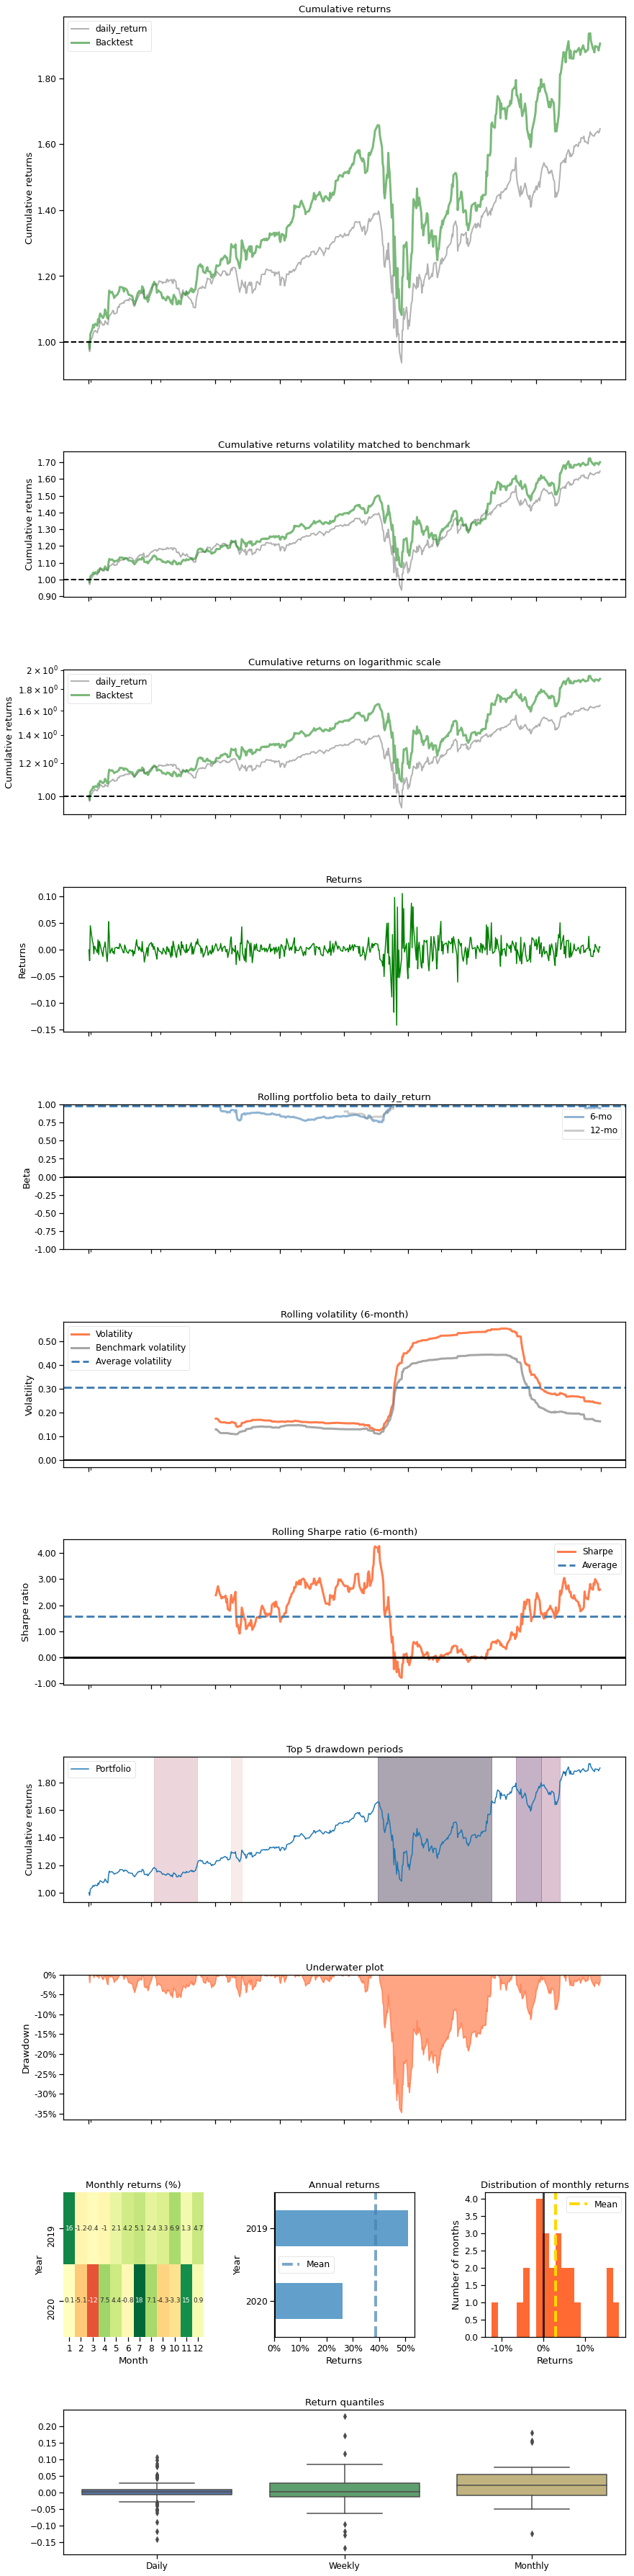

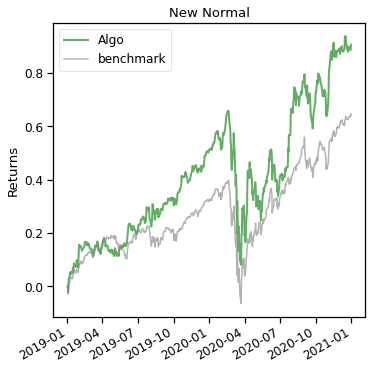

In [37]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [55]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:215180.80359106616
Sharpe:  1.3660817838096861
hit end!


In [56]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.010176
2,2019-01-04,0.028966
3,2019-01-07,0.016591
4,2019-01-08,0.011731
...,...,...
500,2020-12-24,0.009064
501,2020-12-28,-0.002388
502,2020-12-29,-0.005000
503,2020-12-30,0.004505


In [57]:
df_actions.head()

,AMD,BIIB,ES,GWW,WELL
date,,,,,
2019-01-02,0.200000,0.200000,0.200000,0.200000,0.200000
2019-01-03,0.148848,0.148848,0.148848,0.148848,0.404610
2019-01-04,0.104678,0.104678,0.233268,0.284544,0.272833
2019-01-07,0.118532,0.322202,0.118532,0.118532,0.322202
2019-01-08,0.145535,0.145535,0.275748,0.287648,0.145535


In [58]:
df_actions.to_csv('df_actions_ppo_5_1.csv')

In [59]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [60]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.465792
Cumulative returns      1.151808
Annual volatility       0.317001
Sharpe ratio            1.366082
Calmar ratio            1.452750
Stability               0.900910
Max drawdown           -0.320628
Omega ratio             1.329150
Sortino ratio           2.041818
Skew                   -0.200722
Kurtosis               14.045517
Tail ratio              1.151433
Daily value at risk    -0.038220
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,46.579%
Cumulative returns,115.181%
Annual volatility,31.7%
Sharpe ratio,1.37
Calmar ratio,1.45
Stability,0.90
Max drawdown,-32.063%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.06,2020-02-19,2020-03-16,2020-06-03,76
1,11.20,2020-06-05,2020-06-26,2020-07-24,36
2,9.05,2020-10-08,2020-10-30,2020-11-04,20
3,8.31,2020-09-02,2020-09-23,2020-10-05,24
4,7.65,2019-03-19,2019-03-27,2019-06-04,56


Stress Events,mean,min,max
New Normal,0.17%,-14.71%,12.83%


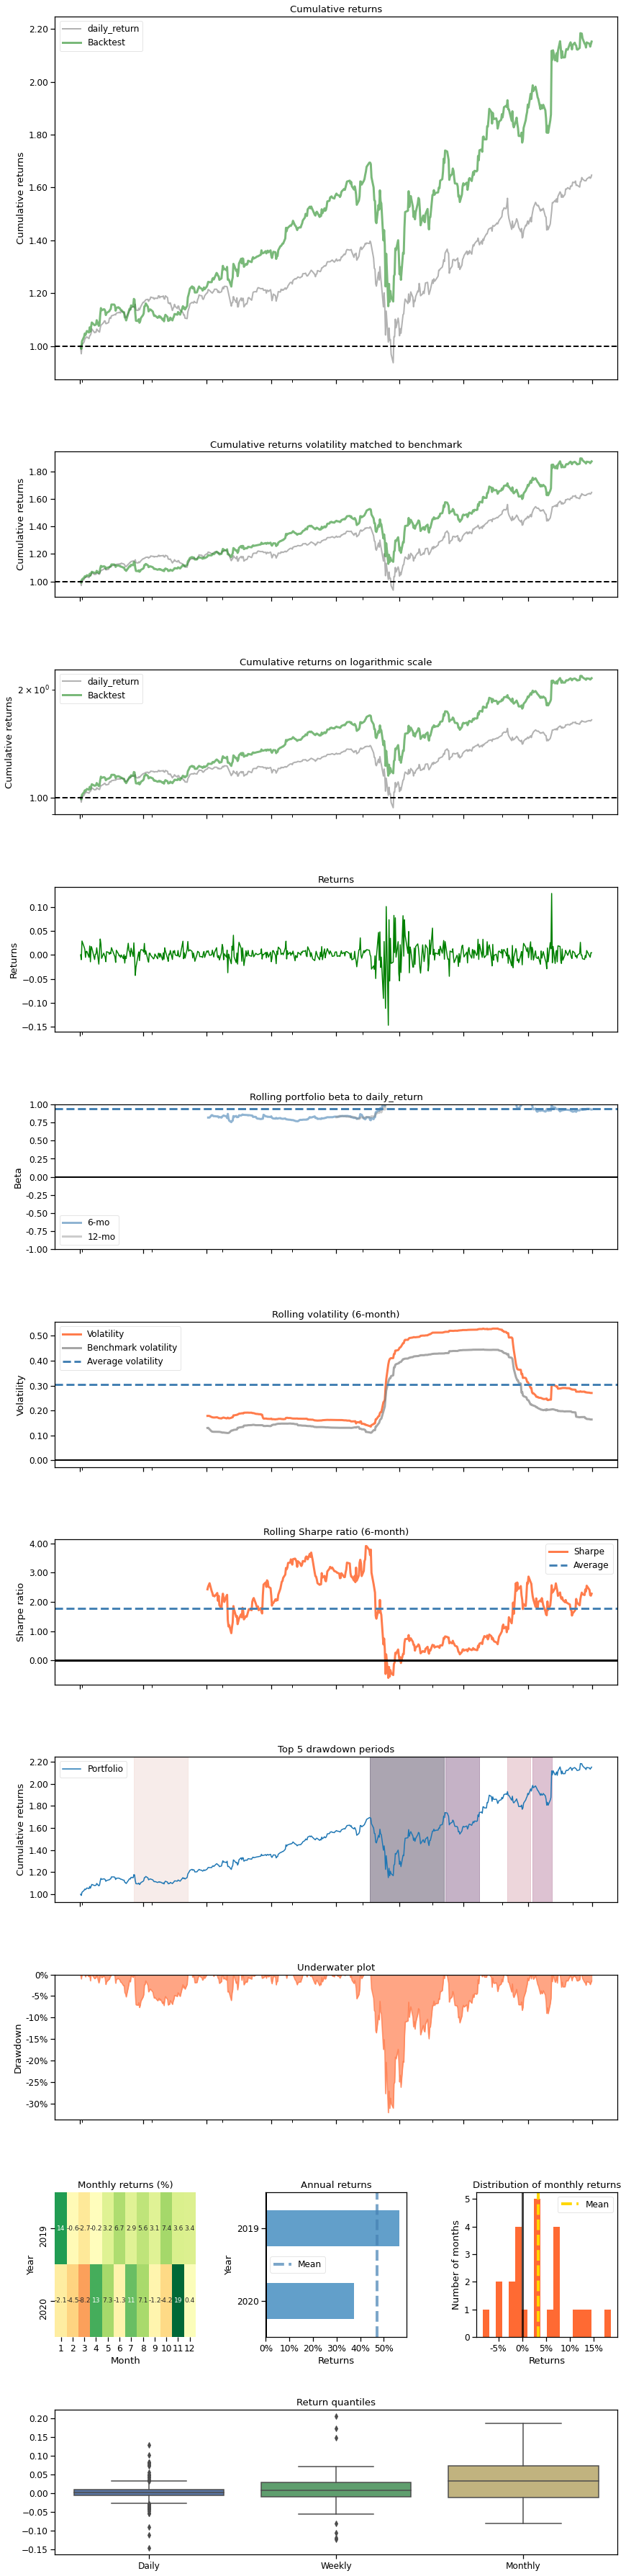

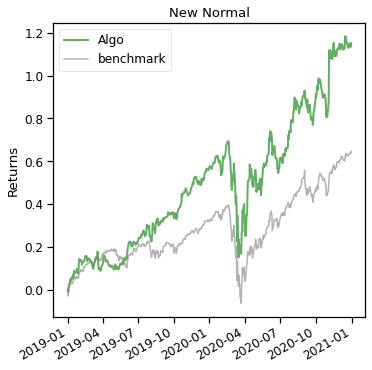

In [61]:
import pyfolio

%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [45]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:209430.1529179679
Sharpe:  1.2315444803643227
hit end!


In [46]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.027356
2,2019-01-04,0.046149
3,2019-01-07,0.030817
4,2019-01-08,0.012220
...,...,...
500,2020-12-24,0.008994
501,2020-12-28,-0.004893
502,2020-12-29,-0.004507
503,2020-12-30,0.009222


In [47]:
df_actions

,AMD,BIIB,ES,GWW,WELL
date,,,,,
2019-01-02,0.200000,0.200000,0.200000,0.200000,0.200000
2019-01-03,0.322202,0.118532,0.118532,0.118532,0.322202
2019-01-04,0.322202,0.118532,0.118532,0.118532,0.322202
2019-01-07,0.322202,0.118532,0.118532,0.118532,0.322202
2019-01-08,0.322202,0.118532,0.118532,0.118532,0.322202
...,...,...,...,...,...
2020-12-24,0.322202,0.118532,0.118532,0.118532,0.322202
2020-12-28,0.322202,0.118532,0.118532,0.118532,0.322202
2020-12-29,0.322202,0.118532,0.118532,0.118532,0.322202


In [48]:
df_actions.to_csv('df_actions_sac_5_1.csv')

In [49]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [50]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.446111
Cumulative returns      1.094302
Annual volatility       0.350044
Sharpe ratio            1.231544
Calmar ratio            1.158253
Stability               0.817660
Max drawdown           -0.385159
Omega ratio             1.279692
Sortino ratio           1.757662
Skew                   -0.762168
Kurtosis               11.685368
Tail ratio              1.041336
Daily value at risk    -0.042391
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,44.611%
Cumulative returns,109.43%
Annual volatility,35.004%
Sharpe ratio,1.23
Calmar ratio,1.16
Stability,0.82
Max drawdown,-38.516%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.52,2020-02-19,2020-03-18,2020-08-04,120
1,12.37,2020-09-02,2020-09-23,2020-11-06,48
2,7.02,2019-07-24,2019-08-05,2019-08-08,12
3,5.32,2020-01-23,2020-01-31,2020-02-10,13
4,5.28,2019-04-05,2019-05-01,2019-06-04,43


Stress Events,mean,min,max
New Normal,0.17%,-15.73%,11.18%


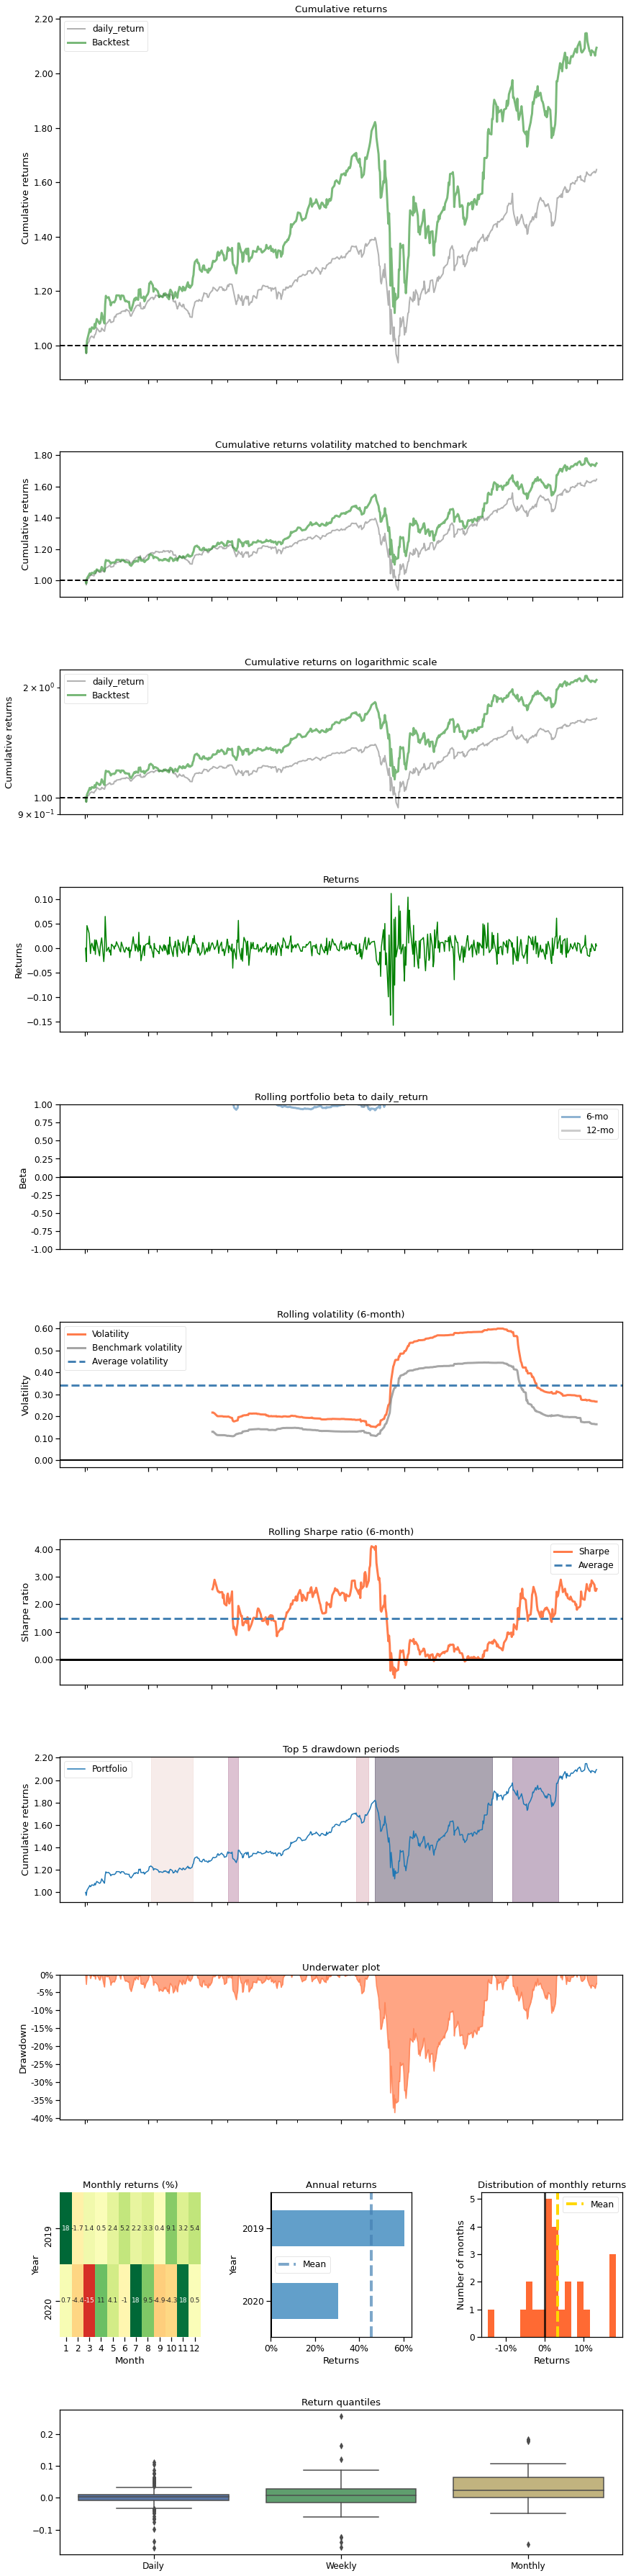

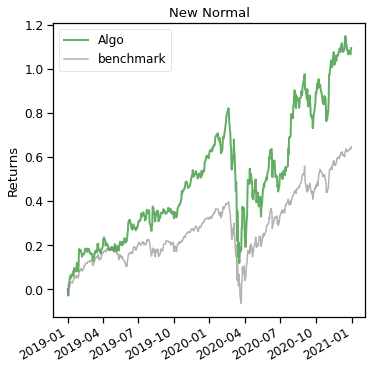

In [51]:
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)